Testing different ways to create a cubed mesh that looks like this:  
https://mpimet.mpg.de/en/communication/multimedia/animations/land-use  

results:  
`pyvista.voxelize` takes a looooong time and doesn't really work currently (although I can probably fix it somehow).  
Thus, I make the mesh manually - by creating pyvista point cloud for the vertices and defining their faces - those create a `polyData` type for the mesh.

In [1]:
import pyvista as pv
import numpy as np
import netCDF4 as nc
import vtk
import matplotlib.pyplot as plt
import gemgis as gg

### Load data

In [2]:
ds = nc.Dataset('../../UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc')

In [3]:
arr = ds["surface_upward_sensible_heat_flux"][0]

In [4]:
fill_value = -999

In [14]:
### test smaller array:
test_arr = arr[344:350,233:240]

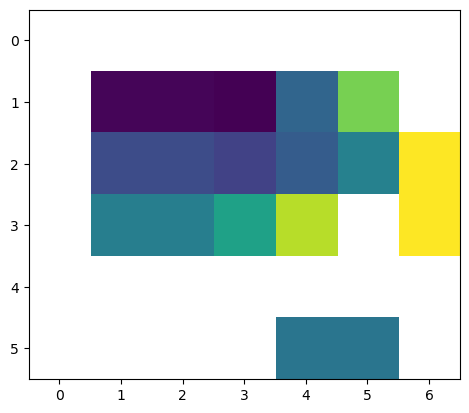

In [15]:
plt.imshow(test_arr)

In [16]:
grid = gg.visualization.create_dem_3d(dem=arr.filled(fill_value=fill_value), 
                                      extent=[0,arr.shape[1],0,arr.shape[0]])

/home/ella/mambaforge/envs/pyvista_basemap/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


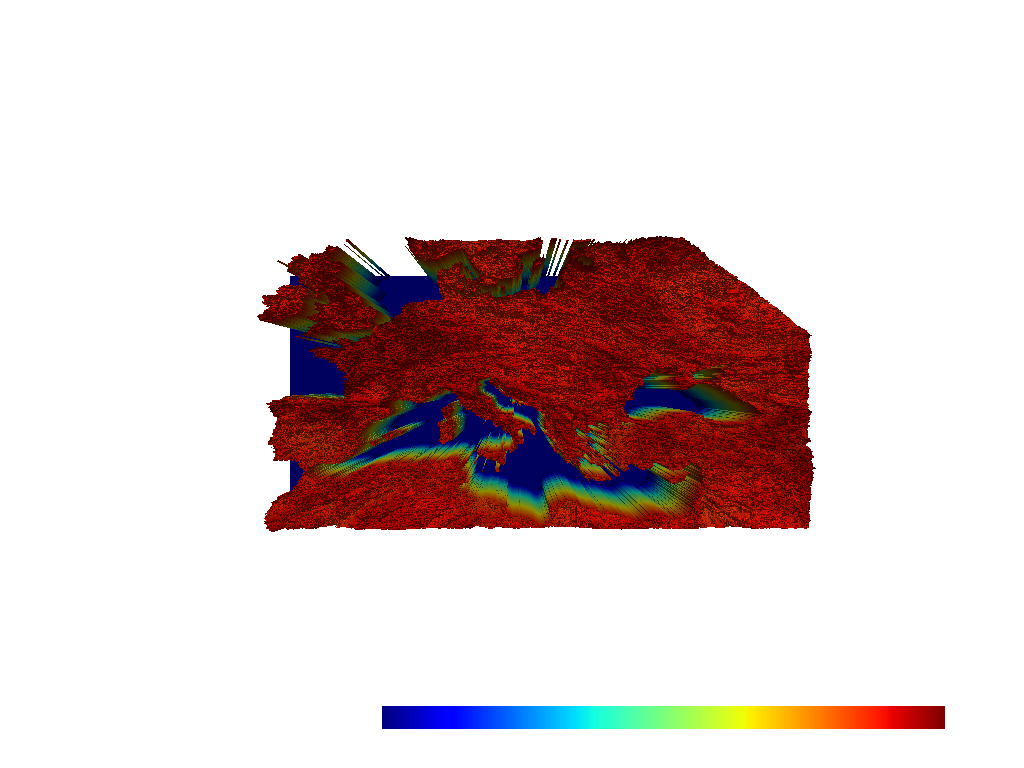

In [17]:
p = pv.Plotter()

p.add_mesh(mesh=grid, cmap='jet')
p.camera_position = 'xy'
p.set_background(color='white')
p.show()

## Approach 1 - pyvista voxelize 
Takes a long time and need to figure out how to make it work.  
Probably won't be used.

In [18]:
voxels = pv.voxelize(grid, density=grid.length/200, check_surface=False)

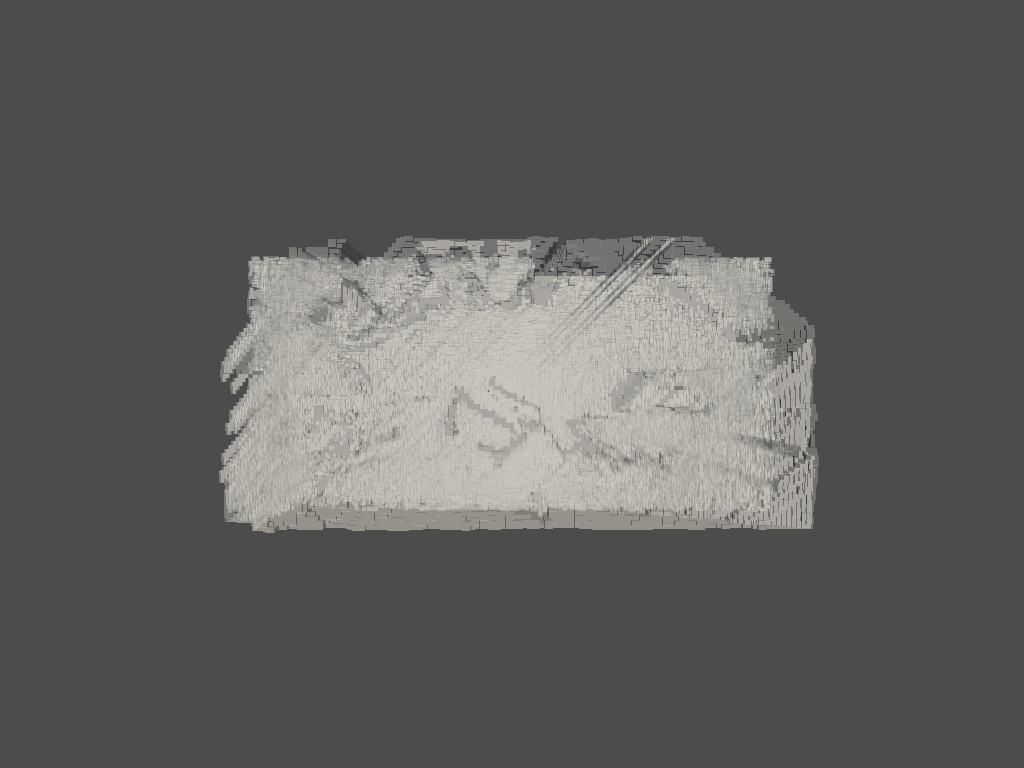

In [19]:
p = pv.Plotter()
p.add_mesh(voxels, color=True, opacity=0.5)
p.camera_position = 'xy'
#p.add_mesh(surface, color="lightblue", opacity=0.5)
p.show()

In [20]:
#clipped = grid.threshold(-200, invert=False, preference='point', all_scalars=True)

In [21]:
# voxels = pv.voxelize(clipped, density=grid.length/400, check_surface=False)
# p = pv.Plotter()
# p.add_mesh(voxels, color=True, opacity=0.5)
# p.camera_position = 'xy'
# #p.add_mesh(surface, color="lightblue", opacity=0.5)
# p.show()

## Approach 2 - cubes from 3D numpy volume
That can work but it creates a huge array - won't fit in memory.  
Thus, will not be used.

In [22]:
filled = test_arr.filled(fill_value=np.nan)

In [23]:
np.nanmin(filled),np.nanmax(filled)

(11.071214, 23.471651)

In [24]:
filled = filled - np.nanmin(filled)

In [25]:
np.nanmin(filled),np.nanmax(filled)

(0.0, 12.400437)

In [26]:
#d3_arr = np.zeros((*filled.shape, 231), dtype=bool)

d3_arr = np.full((*filled.shape, 231), fill_value=np.nan, dtype=np.float32)


In [27]:
for i in range(filled.shape[0]):
    for j in range(filled.shape[1]):
        if not np.isnan(filled[i,j]):
            d3_arr[i,j,:round(filled[i,j])] = 1

In [28]:
grid = pv.UniformGrid()
grid.dimensions = np.array(d3_arr.shape) + 1
grid.origin = (0, 0, 0)  # The bottom left corner of the data set
grid.spacing = (1, 1, 1)  # These are the cell sizes along each axis

In [29]:
grid.cell_data["arr"] = d3_arr.flatten(order="F")

In [30]:
print(f'memory size: {grid.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB


memory size: 0.04 MB


In [31]:
grid

UniformGrid (0x7ffa43fcd8e0)
  N Cells:	9702
  N Points:	12992
  X Bounds:	0.000e+00, 6.000e+00
  Y Bounds:	0.000e+00, 7.000e+00
  Z Bounds:	0.000e+00, 2.310e+02
  Dimensions:	7, 8, 232
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1

In [32]:
arr.shape[0]*arr.shape[1]*232

171919656

In [33]:
clipped = grid.threshold(-1, invert=False, preference='point', all_scalars=True)

In [34]:
del grid

In [35]:
print(f'memory size: {clipped.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB


memory size: 0.01 MB


In [36]:
# p = pv.Plotter()
# p.add_mesh(clipped)#,  scalars='values', nan_opacity=0)
# p.camera_position = 'xy'
# p.show()

In [37]:
#surf = clipped.extract_geometry()

In [38]:
# print(f'memory size: {surf.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB


In [39]:
# p = pv.Plotter()
# p.add_mesh(surf)#,  scalars='values', nan_opacity=0)
# p.camera_position = 'xy'
# p.show()

In [40]:
# del clipped

In [41]:
# voxels = pv.voxelize(surf, check_surface=False) #density=

In [42]:
# p = pv.Plotter()
# p.add_mesh(voxels, show_edges=True)#,  scalars='values', nan_opacity=0)
# p.camera_position = 'xy'
# p.show()

In [43]:
# vol = pv.wrap(d3_arr)

In [ ]:
# p = pv.Plotter()
# p.add_mesh(vol)
# p.camera_position = 'yx'
# p.show()

In [44]:
# p = pv.Plotter()
# p.add_mesh(voxels, color='black', nan_opacity=0)
# p.camera_position = 'xy'
# p.show()

## Approach 3 - Manual construction of mesh and point-cloud

### example:
#### mesh points
`vertices = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0.5, 0.5, -1]])`

#### mesh faces
the first item in each face is the number of vertices (3-triangle, 4-square)  

`faces = np.hstack(`   
`    [`  
`        [4, 0, 1, 2, 3],  # square`  
`        [3, 0, 1, 4],  # triangle`  
`        [3, 1, 2, 4],  # triangle`  
`    ]`  
`)`  

`surf = pv.PolyData(vertices, faces)`


In [151]:
filled = arr.filled(fill_value=np.nan)
filled = filled - np.nanmin(filled)

#### make floor

In [152]:
def make_vertices(arr):

    xs,ys = np.meshgrid(range(arr.shape[0]),range(arr.shape[1]))
    
    vertices_base = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
    
    xs,ys = np.meshgrid(range(arr.shape[0]),[arr.shape[1]])
    vertices_edge_y = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
    
    xs,ys = np.meshgrid(arr.shape[0],range(arr.shape[1]))
    vertices_edge_x = np.vstack((xs.T.flatten(), 
                        ys.T.flatten(),
                        np.zeros(xs.size))).T
        
    return vertices_base, vertices_edge_y, vertices_edge_x

In [153]:
vertices_base, vertices_edge_y, vertices_edge_x = make_vertices(filled)

In [154]:
## floor faces
faces = []
it = np.nditer(filled, flags=['c_index','multi_index'])

for x in it:
    if not np.isnan(x):
        #print(it.index, it.multi_index)
        neigh_right_idx = it.index+1 if it.multi_index[1]!=filled.shape[1]-1 else filled.size + it.multi_index[0] 
        neigh_down_idx = it.index+filled.shape[1] \
                                if it.multi_index[0]!=filled.shape[0]-1 \
                                else filled.size + filled.shape[0] + it.multi_index[1]
        neigh_diag_idx = it.index+filled.shape[1]+1
        if neigh_down_idx>filled.size:
            neigh_diag_idx = neigh_down_idx+1
        elif neigh_right_idx>filled.size-1:
            neigh_diag_idx = neigh_right_idx+1

        if it.multi_index[0]==filled.shape[0]:
            add_y_idx += vertices.shape[0] + edge_vertices_y.shape[0]
        faces.append(np.array([4,
                               it.index,
                               neigh_right_idx,
                               neigh_diag_idx,
                               neigh_down_idx,
                              ]))
    

In [155]:
vertices = np.concatenate((vertices_base,
                           vertices_edge_y,
                           vertices_edge_x
                          ))
#vertices

In [156]:
n_floor_faces = len(faces)
n_floor_faces

450673

In [157]:
# ceiling faces:
n_v_floor = vertices.shape[0]
n_v_base = vertices_base.shape[0]

it = np.nditer(filled, flags=['c_index','multi_index'])

for x in it:
    #print(x)
    if not np.isnan(x):
        faces.append(np.array([4,
                               n_v_floor+it.index,
                               n_v_floor+n_v_base+it.index,
                               n_v_floor+n_v_base*2+it.index,
                               n_v_floor+n_v_base*3+it.index,
                              ]))

In [158]:
len(faces)

901346

In [159]:
vertices_ceil = vertices_base.copy()
vertices_ceil[:,2] = filled.flatten()

vertices = np.concatenate((vertices,
                vertices_ceil,
                vertices_ceil+[0,1,0],
                vertices_ceil+[1,1,0],
                vertices_ceil+[1,0,0],
               ))

In [160]:
#faces

In [161]:
## faces sides:

for i in range(n_floor_faces):
    faces.append(np.array([4,
                           faces[i][1],
                           faces[i][2],
                           faces[n_floor_faces+i][2],
                           faces[n_floor_faces+i][1],
                          ]))
    faces.append(np.array([4,
                           faces[i][1],
                           faces[i][4],
                           faces[n_floor_faces+i][4],
                           faces[n_floor_faces+i][1],
                          ]))
    faces.append(np.array([4,
                           faces[i][2],
                           faces[i][3],
                           faces[n_floor_faces+i][3],
                           faces[n_floor_faces+i][2],
                          ]))
    faces.append(np.array([4,
                           faces[i][3],
                           faces[i][4],
                           faces[n_floor_faces+i][4],
                           faces[n_floor_faces+i][3],
                          ]))


In [162]:
surf = pv.PolyData(vertices, faces)
#surf = surf.smooth(n_iter=100)

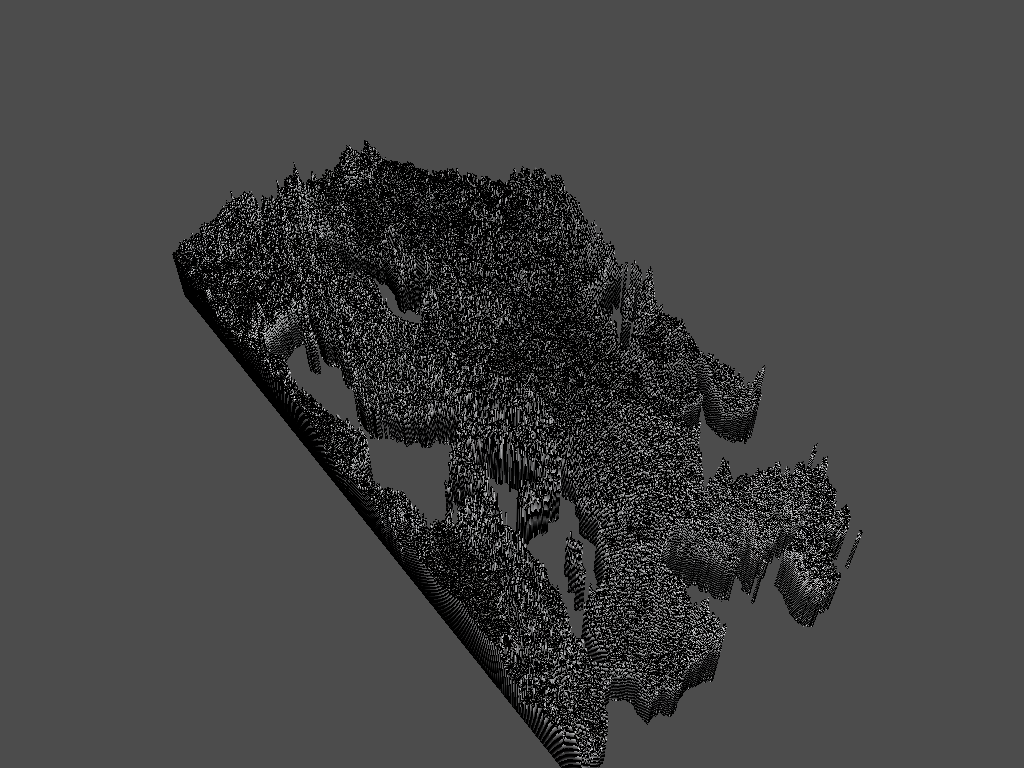

In [184]:
p = pv.Plotter()
p.add_mesh(surf, color='white', )#,  show_edges=True)
#p.camera_position = 'zy'
p.camera.position = (-500, -400, 2000)
p.show()

In [81]:
np.savetxt('/home/ella/Desktop/faces.txt', 
           np.asarray(faces), fmt='%i')

np.savetxt('/home/ella/Desktop/floor_idxs.txt', 
           np.asarray(vertices), fmt='%.2f')

In [ ]:
print(f'memory size: {surf.actual_memory_size/1024:.2f} MB') # actual_memory_size - kibibytes, thus ~/1024 for MB
